# Naive Bayes Bi-gram

# Start

In [53]:
import csv
import pandas as pd
import os,re
import numpy as np
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from functools import reduce
import nltk
from nltk.util import ngrams
from nltk import PorterStemmer
import matplotlib.pyplot as plt


target_file = 'reviews.csv'

test_data = []
train_data = []

ps = PorterStemmer()
def _clean_tokenize_sentence(sentence):
    
    words = []
    for word in sentence.split(" "):
        token = re.sub('[^A-Za-z0-9]+', '', word).strip().lower()
        
        if token.isdigit():
            continue
            
        token = ps.stem(token)
        
        if len(token) and token not in list(ENGLISH_STOP_WORDS):
            words.append(token)  
    
    conv_words = [x[0] for x in nltk.pos_tag(words) if x[1] not in ['NN', 'PRP', 'TO', 'IN']]
    return sorted(conv_words)
def convert_file():
    if os.path.isfile(target_file):
        return

    with open('reviews.tsv', 'rb') as fin:
        cr = csv.reader(fin, delimiter='\t')
        filecontents = [line for line in cr]

    with open(target_file, 'wb') as fou:
        cw = csv.writer(fou, quoting=csv.QUOTE_ALL, escapechar='\\')
        cw.writerows(filecontents)


def divide_by_rankings():
    
    colnames = ['rating', 'text']
    contents = pd.read_csv(target_file, names=colnames, header=None)

    contents['rating'] = contents['rating'].astype(int)

    global train_data
    global test_data
    train_data, test_data = train_test_split(contents, test_size=0.2)

    negative_rankings = train_data[train_data['rating'] < 3]
    neutral_documents = train_data[train_data['rating'] == 3]
    positive_rankings = train_data[train_data['rating'] > 3]

    return negative_rankings, neutral_documents, positive_rankings


def tokenize(docs, file_name):
    if os.path.isfile(file_name):
        os.remove(file_name)

    initialtokens = docs['text'].values
    tokens=[]
    
    for token in initialtokens:
        tupletokens = _clean_tokenize_sentence(token)
        tokens.append(tupletokens)
    bigram_list =[]
    for i in tokens:
        bigrams = ngrams(i,2)
        bigram_list.append(tuple(bigrams))
    with open(file_name, 'w', encoding="utf-8") as the_file:
        for j in bigram_list:          
            for k in j:
                the_file.write(str(k)+ '\n')

def main():
    convert_file()


if __name__ == "__main__":
    main()

# Breaking by Rankings

In [54]:
negative_docs, neutral_docs, positive_docs = divide_by_rankings()

# Tokenize

In [55]:
tokenize(negative_docs, 'negative_bigram.txt')
tokenize(neutral_docs, 'neutral_bigram.txt')
tokenize(positive_docs, 'positive_bigram.txt')

In [56]:
mega_doc_pos = open(os.getcwd() + '\\positive_bigram.txt', 'r').read()
mega_doc_neg = open(os.getcwd() + '\\negative_bigram.txt', 'r').read()
mega_doc_neu = open(os.getcwd() + '\\neutral_bigram.txt', 'r').read()


# Creating Vocab List

In [57]:
total_words_in_pos = [str(x.lower()) for x in mega_doc_pos.split('\n')]
total_words_in_neg = [str(x.lower()) for x in mega_doc_neg.split('\n')]

total_words = [str(x.lower()) for x in (mega_doc_neg.split('\n'))]
total_words += [str(x.lower()) for x in (mega_doc_pos.split('\n'))]
vocab_pos = list(set(total_words_in_pos))
vocab_neg = list(set(total_words_in_neg))
vocab = list(set(total_words))

In [58]:
positive_class_probability = 0.95
negaitive_class_probability = 0.05

# Classification

In [59]:
def classify(sentence):
    review = {1: "Positive", 0: "Negative"}
    sentence_probab_pos = {}
    sentence_probab_neg = {}
    tokens=_clean_tokenize_sentence(sentence)
    bigram_list =[]
    bigrams = ngrams(tokens,2)
    for x in bigrams:
        x = str(x)
        x = x.lower()
        count_of_word_in_vocab = total_words_in_pos.count(x)
        sentence_probab_pos[x] = float(((count_of_word_in_vocab) + 1)) /  (len(total_words_in_pos) +len(vocab))
        count_of_word_in_vocab = total_words_in_neg.count(x)
        sentence_probab_neg[x] = float(((count_of_word_in_vocab) + 1)) /  (len(total_words_in_neg) +len(vocab))
    pos = np.array(list(sentence_probab_pos.values()))
    neg = np.array(list(sentence_probab_neg.values()))
    positive = positive_class_probability * np.prod(pos)
    negative = negaitive_class_probability * np.prod(neg)
    label = int(positive > negative)
    return label

# Testing some reviews

In [60]:
sentence1 = "Ok~ but I think the Keirsey Temperment Test is more accurate - and cheaper.  This book has its good points. If anything, it helps you put into words what you want  from a supervisor, but it is not very accurate. The online test does not account for a difference between when 2 of their options are both exactly like you, or if they don't describe you at all. This messes up the results, and it did not describe me very well. I am not just in denial. I have taken a lot of personality type tests, like the Keirsey Temperment sorter and have a pretty good idea of my strengths. So, although this book is pretty good in making you understand the importance of incouraging your strengths, it still leaves you wondering about how you fit in to their terminology.  As for using this book as a manager to better serve your employees, I'v seen it done and it does not necessarily work because the strengths spit out for people were not wholly accurate. The company I work for has done this, and most of the people who were shifted around to better serve their strengths (according to this book) are very unhappy in their new positions.  Your money can be spent better elsewhere. I say its only worth about $10"
sentence2 = "spiral bound independent study  Though this book does present all the necessary information for learning about abnormal psychology, it's the dryest, most aesthetically difficult to read textbook... especially if you happen to be studying the material online/through independent study.  The publisher needs to redesign the book and/or you need to have a better online course professor. It feels nearly impossible to be interested in this material (which is interesting in itself) if you have to read the textbook front to back on your own without any instruction."
sentence3 = "Excellent resource for principals!  I am ordering copies for all 23 middle school principals and the two assistant principals leading two middle school programs in the Milwaukee Public Schools system. We will use Wheatley's book as the primary resource  for our professional growth at our MPS Middle School Principals  Collaborative institute August 9-11, 1999. We are not just concerned with  reform; we seek renewal as well. Wheatley provides the basis. She notes  that Einstein said that  a problem cannot be solved from the same  consciousness that created it. The entire book is a marvelous exploration  of this philosophy"
sentence4 = "Best Leadership book I have read  I have been studing leadership for over 15 years both by reading and experience.  I consider this book to be the best book I have read because it describes leadership as a learned activity.  It also says that leadership is in motivating people to do their own work in solving difficult problems. I found that as President of my congregation I was continually going back to the concepts in the book to lead it through a very difficult situation involving placement of the flags in the sanctuary.  It was very difficult to get people to do their own work and not try to step in to solve everything. (That would have been impossible anyway) I found that he described President Lyndon Johnson as a successful leader (civil rights) and unsuccessful leader ( Vietnam).  His discussion on leading without authority is new ground for me.    If you want to discuss the book with others there is an on-line book study at the Work and Worship Institute website. I found it was a good way for me to get more from the book. This is a great book with great stories of a variety of leaders in our society."

In [61]:
print (classify(sentence1))
print (classify(sentence2))
print (classify(sentence3))
print (classify(sentence4))

0
0
1
1


# Confusion Matrix

In [62]:
predictions = []
    
def _map_rating(rating):    
    return +(rating > 3)

def get_confusion_matrix():    
    conf_matrix = [0, 0, 0, 0]
    count = 0
    
    rating_map = {
        '00': 0,  #TN
        '01': 1,  #FN
        '10': 2,  #FP
        '11': 3   #TP
    }
    
    for idx, record in test_data.iterrows():
        
        if not count % 500:
            print (count)
            
        count += 1
            
        true_rating = _map_rating(+record['rating'])
        predicted_rating = classify(record['text'])

        predictions.append(predicted_rating)
        
        rating = '{}{}'.format(str(predicted_rating), str(true_rating))
        conf_matrix[rating_map.get(rating)] += 1
    
    return conf_matrix

In [63]:
conf_matrix = get_confusion_matrix()
print (conf_matrix)

0
500
1000
1500
[225, 438, 172, 1165]


# ROC Curve

In [64]:
def CreateROCCurve(y_test, predictions, classifier_name):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic for ' + classifier_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

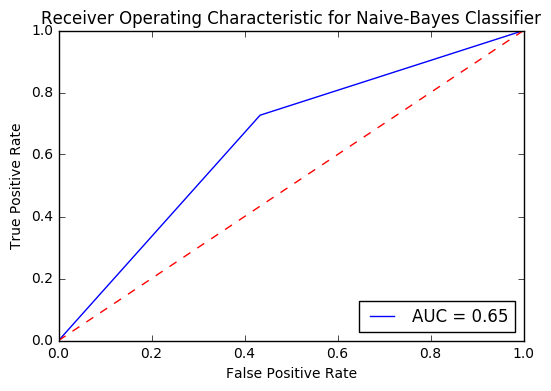

Accuracy is 0.695
Precision is 0.871
Recall is 0.727


In [65]:
from sklearn import metrics
import matplotlib.pyplot as plt
test_data_ratings = [int(_map_rating(x)) for x in test_data['rating'].values]

CreateROCCurve(test_data_ratings, predictions, 'Naive-Bayes Classifier')

tn = conf_matrix[0]
fn = conf_matrix[1]
fp = conf_matrix[2]
tp = conf_matrix[3]

accuracy = float(tn+tp)/(sum(conf_matrix))
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)

print ("Accuracy is %.3f" % accuracy)
print ("Precision is %.3f" % precision)
print ("Recall is %.3f" % recall)